In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from functions.datasets import get_loaders
from functions.drawing import save_images_with_bboxes
from functions.loop_management import EarlyStopping
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [10]:
dataset, train_loader, valid_loader, test_loader = get_loaders(
    os.path.join("data", "images"),
    os.path.join("data", "coco_annotations.json"),
    prefetch_factor=16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
cuda


In [11]:
class BoundingBoxModel(nn.Module):
    def __init__(self):
        super(BoundingBoxModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = self._initialize_fc1()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._run_first_layers(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _initialize_fc1(self) -> nn.Linear:
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 200)
            x = self._run_first_layers(dummy_input)
            input_size = x.size(1)

            return nn.Linear(input_size, 128)

    def _run_first_layers(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)

        return x

In [12]:
model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")

    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()

            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)

    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss, 
        model, 
        path=os.path.join("checkpoints", "checkpoint_2_bigger_basic.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 220/220 [00:14<00:00, 15.53it/s, Train Loss=17.8]


Epoch 1, Loss: 17.80282535986467


Epoch 1/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.46it/s, Val Loss=12.8]


Validation Loss: 12.796042377298528
Validation loss decreased (inf --> 12.796042).  Saving model ...


Epoch 2/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.04it/s, Train Loss=9.88]


Epoch 2, Loss: 9.882577131011269


Epoch 2/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.73it/s, Val Loss=9.39]


Validation Loss: 9.388150761344216
Validation loss decreased (12.796042 --> 9.388151).  Saving model ...


Epoch 3/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.03it/s, Train Loss=8.68]


Epoch 3, Loss: 8.679110687429255


Epoch 3/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.35it/s, Val Loss=8.85]


Validation Loss: 8.845468824559992
Validation loss decreased (9.388151 --> 8.845469).  Saving model ...


Epoch 4/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.06it/s, Train Loss=8.34]


Epoch 4, Loss: 8.336640524864197


Epoch 4/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.64it/s, Val Loss=8.77]


Validation Loss: 8.772769732908769
Validation loss decreased (8.845469 --> 8.772770).  Saving model ...


Epoch 5/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.13it/s, Train Loss=7.95]


Epoch 5, Loss: 7.94992947361686


Epoch 5/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.22it/s, Val Loss=7.48]


Validation Loss: 7.478738862817938
Validation loss decreased (8.772770 --> 7.478739).  Saving model ...


Epoch 6/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.17it/s, Train Loss=7.63]


Epoch 6, Loss: 7.6280383066697555


Epoch 6/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.60it/s, Val Loss=8.15]


Validation Loss: 8.152711978825655
EarlyStopping counter: 1 out of 7


Epoch 7/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.12it/s, Train Loss=7.42]


Epoch 7, Loss: 7.422515084526756


Epoch 7/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.26it/s, Val Loss=7.1] 


Validation Loss: 7.10187968340787
Validation loss decreased (7.478739 --> 7.101880).  Saving model ...


Epoch 8/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.13it/s, Train Loss=7.14]


Epoch 8, Loss: 7.143482119386847


Epoch 8/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.87it/s, Val Loss=7.12]


Validation Loss: 7.11923959905451
EarlyStopping counter: 1 out of 7


Epoch 9/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.07it/s, Train Loss=7.14]


Epoch 9, Loss: 7.144856474616311


Epoch 9/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.77it/s, Val Loss=6.92]


Validation Loss: 6.921910017186945
Validation loss decreased (7.101880 --> 6.921910).  Saving model ...


Epoch 10/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.25it/s, Train Loss=6.98]


Epoch 10, Loss: 6.977147139202465


Epoch 10/25 - Validation: 100%|██████████| 220/220 [00:13<00:00, 16.56it/s, Val Loss=6.48]


Validation Loss: 6.476312557133761
Validation loss decreased (6.921910 --> 6.476313).  Saving model ...


Epoch 11/25 - Training: 100%|██████████| 220/220 [00:14<00:00, 14.86it/s, Train Loss=6.86]


Epoch 11, Loss: 6.859358150308783


Epoch 11/25 - Validation: 100%|██████████| 220/220 [00:13<00:00, 16.04it/s, Val Loss=6.39]


Validation Loss: 6.3916933709924875
Validation loss decreased (6.476313 --> 6.391693).  Saving model ...


Epoch 12/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.74it/s, Train Loss=6.59]


Epoch 12, Loss: 6.593047079173002


Epoch 12/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.09it/s, Val Loss=6.9] 


Validation Loss: 6.899664176594127
EarlyStopping counter: 1 out of 7


Epoch 13/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.18it/s, Train Loss=6.48]


Epoch 13, Loss: 6.482289868051356


Epoch 13/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.83it/s, Val Loss=6.3] 


Validation Loss: 6.303082585334778
Validation loss decreased (6.391693 --> 6.303083).  Saving model ...


Epoch 14/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.18it/s, Train Loss=6.39]


Epoch 14, Loss: 6.390902688286522


Epoch 14/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.89it/s, Val Loss=7.2] 


Validation Loss: 7.199515821717002
EarlyStopping counter: 1 out of 7


Epoch 15/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.26it/s, Train Loss=6.15]


Epoch 15, Loss: 6.152656360106035


Epoch 15/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.63it/s, Val Loss=7.87]


Validation Loss: 7.874467088959434
EarlyStopping counter: 2 out of 7


Epoch 16/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.30it/s, Train Loss=6.26]


Epoch 16, Loss: 6.255000368031588


Epoch 16/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.74it/s, Val Loss=5.81]


Validation Loss: 5.809366696531122
Validation loss decreased (6.303083 --> 5.809367).  Saving model ...


Epoch 17/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.26it/s, Train Loss=5.91]


Epoch 17, Loss: 5.907765191251581


Epoch 17/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.46it/s, Val Loss=5.65]


Validation Loss: 5.649221330339258
Validation loss decreased (5.809367 --> 5.649221).  Saving model ...


Epoch 18/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.02it/s, Train Loss=5.8] 


Epoch 18, Loss: 5.800388326428154


Epoch 18/25 - Validation: 100%|██████████| 220/220 [00:13<00:00, 16.47it/s, Val Loss=5.83]


Validation Loss: 5.82779663476077
EarlyStopping counter: 1 out of 7


Epoch 19/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.08it/s, Train Loss=5.77]


Epoch 19, Loss: 5.770462808825753


Epoch 19/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.88it/s, Val Loss=5.24]


Validation Loss: 5.244150286371058
Validation loss decreased (5.649221 --> 5.244150).  Saving model ...


Epoch 20/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.40it/s, Train Loss=5.64]


Epoch 20, Loss: 5.637431958588687


Epoch 20/25 - Validation: 100%|██████████| 220/220 [00:13<00:00, 16.84it/s, Val Loss=5.59]


Validation Loss: 5.592467900839719
EarlyStopping counter: 1 out of 7


Epoch 21/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.80it/s, Train Loss=5.71]


Epoch 21, Loss: 5.705780739134008


Epoch 21/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.73it/s, Val Loss=7.41]


Validation Loss: 7.414481655034152
EarlyStopping counter: 2 out of 7


Epoch 22/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.28it/s, Train Loss=5.51]


Epoch 22, Loss: 5.507802792028947


Epoch 22/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.89it/s, Val Loss=5.24]


Validation Loss: 5.238511230728843
Validation loss decreased (5.244150 --> 5.238511).  Saving model ...


Epoch 23/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.26it/s, Train Loss=5.42]


Epoch 23, Loss: 5.424646208503029


Epoch 23/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.97it/s, Val Loss=5.11]


Validation Loss: 5.111734409765764
Validation loss decreased (5.238511 --> 5.111734).  Saving model ...


Epoch 24/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.44it/s, Train Loss=5.26]


Epoch 24, Loss: 5.26445200660012


Epoch 24/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.55it/s, Val Loss=5.18]


Validation Loss: 5.180119008367712
EarlyStopping counter: 1 out of 7


Epoch 25/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.25it/s, Train Loss=5.16]


Epoch 25, Loss: 5.158998748389157


Epoch 25/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 16.97it/s, Val Loss=5.25]

Validation Loss: 5.254776079004461
EarlyStopping counter: 2 out of 7
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

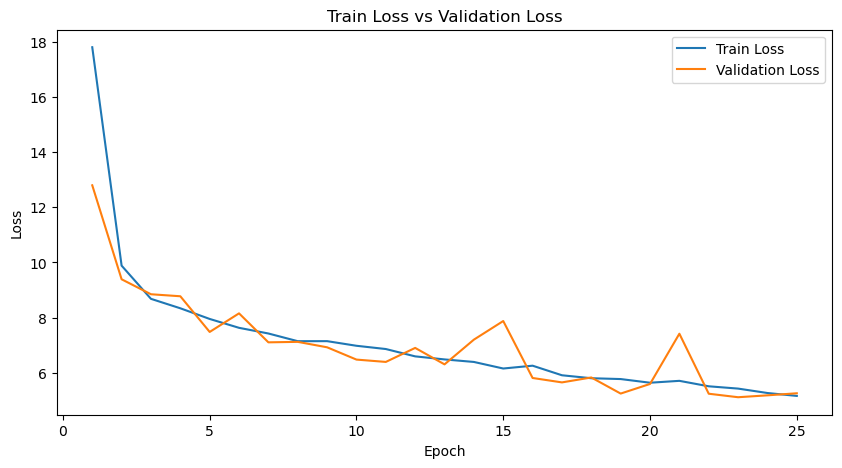

In [14]:
plot_losses(num_epochs, train_losses, val_losses)

In [15]:
model.eval()
test_loss = 0.0
test_loader_tqdm = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in test_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)
        outputs = model(images)
        loss = criterion(outputs, bboxes)
        test_loss += loss.item()

        test_loader_tqdm.set_postfix({"Test Loss": test_loss / len(test_loader)})

test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss}")

Testing: 100%|██████████| 220/220 [00:12<00:00, 17.50it/s, Test Loss=5.25]

Test Loss: 5.254776079004461


In [16]:
save_images_with_bboxes(model, test_loader, device, dataset, "2_bigger_basic_output_imgs")

Images with bounding boxes have been saved to data\2_bigger_basic_output_imgs


In [17]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_loss,
}
torch.save(checkpoint, os.path.join("checkpoints", "checkpoint_2_bigger_basic.pt"))